In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
house_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
house_testdf = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
house_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
#data type 선별
house_objects = house_df.dtypes[house_df.dtypes == 'object'].index
print(house_objects)
print('-'*80)
house_numerical = house_df.dtypes[house_df.dtypes != 'object'].index
print(house_numerical)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
--------------------------------------------------------------------------------
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea'

In [6]:
from collections import Counter

def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers

Outliers_to_drop = detect_outliers(house_df, 2, ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'])

house_df = house_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [7]:
house_df.shape

(1338, 81)

In [8]:
for col in house_df.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (house_df[col].isnull().sum() / house_df[col].shape[0]))
    print(msperc)

column:         Id	 Percent of NaN value: 0.00%
column: MSSubClass	 Percent of NaN value: 0.00%
column:   MSZoning	 Percent of NaN value: 0.00%
column: LotFrontage	 Percent of NaN value: 17.12%
column:    LotArea	 Percent of NaN value: 0.00%
column:     Street	 Percent of NaN value: 0.00%
column:      Alley	 Percent of NaN value: 94.10%
column:   LotShape	 Percent of NaN value: 0.00%
column: LandContour	 Percent of NaN value: 0.00%
column:  Utilities	 Percent of NaN value: 0.00%
column:  LotConfig	 Percent of NaN value: 0.00%
column:  LandSlope	 Percent of NaN value: 0.00%
column: Neighborhood	 Percent of NaN value: 0.00%
column: Condition1	 Percent of NaN value: 0.00%
column: Condition2	 Percent of NaN value: 0.00%
column:   BldgType	 Percent of NaN value: 0.00%
column: HouseStyle	 Percent of NaN value: 0.00%
column: OverallQual	 Percent of NaN value: 0.00%
column: OverallCond	 Percent of NaN value: 0.00%
column:  YearBuilt	 Percent of NaN value: 0.00%
column: YearRemodAdd	 Percent of

In [9]:
for col in house_testdf.columns:
    msperc = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (house_testdf[col].isnull().sum() / house_testdf[col].shape[0]))
    print(msperc)

column:         Id	 Percent of NaN value: 0.00%
column: MSSubClass	 Percent of NaN value: 0.00%
column:   MSZoning	 Percent of NaN value: 0.27%
column: LotFrontage	 Percent of NaN value: 15.56%
column:    LotArea	 Percent of NaN value: 0.00%
column:     Street	 Percent of NaN value: 0.00%
column:      Alley	 Percent of NaN value: 92.67%
column:   LotShape	 Percent of NaN value: 0.00%
column: LandContour	 Percent of NaN value: 0.00%
column:  Utilities	 Percent of NaN value: 0.14%
column:  LotConfig	 Percent of NaN value: 0.00%
column:  LandSlope	 Percent of NaN value: 0.00%
column: Neighborhood	 Percent of NaN value: 0.00%
column: Condition1	 Percent of NaN value: 0.00%
column: Condition2	 Percent of NaN value: 0.00%
column:   BldgType	 Percent of NaN value: 0.00%
column: HouseStyle	 Percent of NaN value: 0.00%
column: OverallQual	 Percent of NaN value: 0.00%
column: OverallCond	 Percent of NaN value: 0.00%
column:  YearBuilt	 Percent of NaN value: 0.00%
column: YearRemodAdd	 Percent of

In [10]:
for col in house_numerical:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(house_df[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(house_df[col].kurt())  
         )

Id              Skewness: 00.00     Kurtosis: -01.19
MSSubClass      Skewness: 01.37     Kurtosis: 001.49
LotFrontage     Skewness: 01.59     Kurtosis: 013.04
LotArea         Skewness: 07.78     Kurtosis: 123.55
OverallQual     Skewness: 00.16     Kurtosis: -00.05
OverallCond     Skewness: 00.74     Kurtosis: 001.23
YearBuilt       Skewness: -0.58     Kurtosis: -00.60
YearRemodAdd    Skewness: -0.52     Kurtosis: -01.27
MasVnrArea      Skewness: 02.69     Kurtosis: 011.04
BsmtFinSF1      Skewness: 00.65     Kurtosis: -00.50
BsmtFinSF2      Skewness: 04.86     Kurtosis: 026.86
BsmtUnfSF       Skewness: 00.87     Kurtosis: 000.29
TotalBsmtSF     Skewness: 00.29     Kurtosis: 001.17
1stFlrSF        Skewness: 00.66     Kurtosis: 000.02
2ndFlrSF        Skewness: 00.77     Kurtosis: -00.80
LowQualFinSF    Skewness: 12.74     Kurtosis: 170.50
GrLivArea       Skewness: 00.66     Kurtosis: 000.54
BsmtFullBath    Skewness: 00.56     Kurtosis: -00.96
BsmtHalfBath    Skewness: 04.91     Kurtosis: 

<AxesSubplot:>

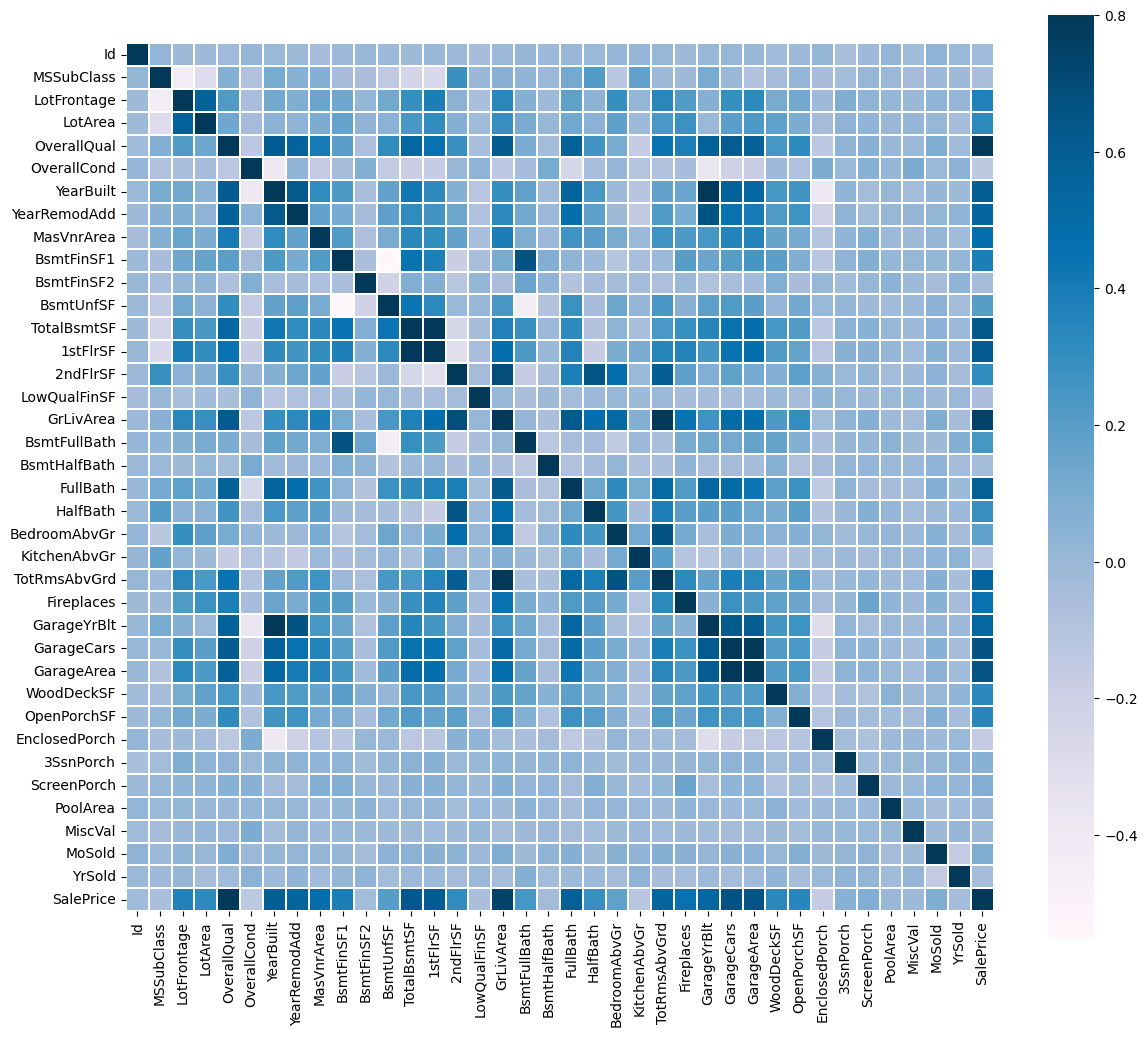

In [11]:
corr_data = house_df[['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
                      'MiscVal', 'MoSold', 'YrSold', 'SalePrice']]

colormap = plt.cm.PuBu
f, ax = plt.subplots(figsize = (14,12))
sns.heatmap(corr_data.corr(),square = True, linewidths = 0.1,
           cmap = colormap, linecolor = "white", vmax=0.8)

In [12]:
for catg in list(house_objects) :
    print(house_df[catg].value_counts())
    print('#'*50)

RL         1055
RM          197
FV           65
RH           14
C (all)       7
Name: MSZoning, dtype: int64
##################################################
Pave    1335
Grvl       3
Name: Street, dtype: int64
##################################################
Grvl    42
Pave    37
Name: Alley, dtype: int64
##################################################
Reg    859
IR1    440
IR2     32
IR3      7
Name: LotShape, dtype: int64
##################################################
Lvl    1211
Bnk      52
HLS      48
Low      27
Name: LandContour, dtype: int64
##################################################
AllPub    1338
Name: Utilities, dtype: int64
##################################################
Inside     972
Corner     235
CulDSac     81
FR2         46
FR3          4
Name: LotConfig, dtype: int64
##################################################
Gtl    1275
Mod      56
Sev       7
Name: LandSlope, dtype: int64
##################################################
NAmes      20

##### https://www.kaggle.com/code/kongnyooong/house-price-tutorial-for-korean-beginners/notebook
##### 위 코드 참고해서 작성되었습니다.

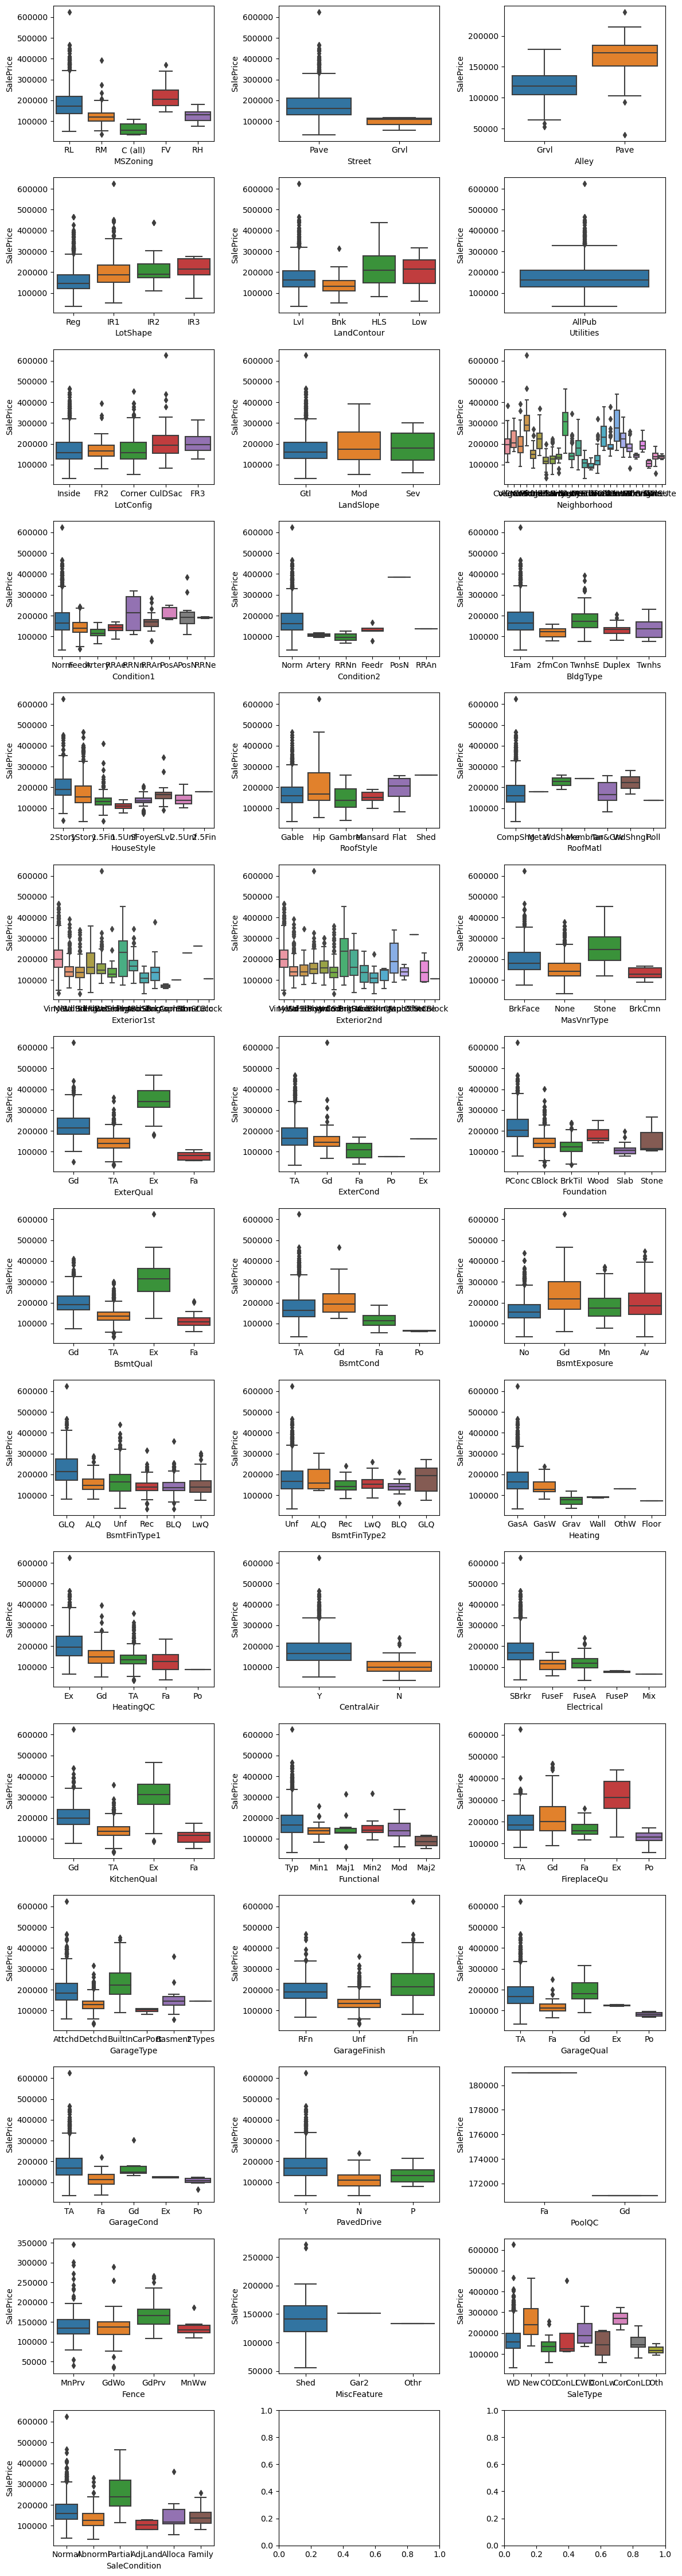

In [13]:
li_cat_feats = list(house_objects)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=house_df["SalePrice"], data=house_df, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()

In [14]:
#각 변수들 가격에 영향 미치는 정도별 정리
num_strong_corr = ['SalePrice','OverallQual','TotalBsmtSF','GrLivArea','GarageCars',
                   'FullBath','YearBuilt','YearRemodAdd']

num_weak_corr = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
                 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'BsmtFullBath',
                 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

catg_strong_corr = ['MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual',
                    'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]

Skewness: -0.032026
Kurtosis: 0.571897


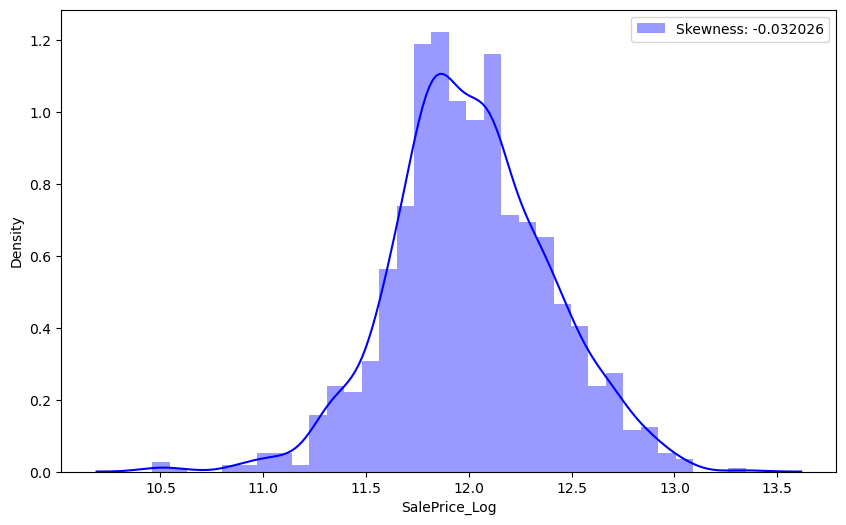

In [15]:
#saleprice 가격 정규근사화
house_df["SalePrice_Log"] = house_df["SalePrice"].map(lambda i:np.log(i) if i>0 else 0)

f, ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(house_df["SalePrice_Log"], color = "b", label="Skewness: {:2f}".format(house_df["SalePrice_Log"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness: %f" % house_df['SalePrice_Log'].skew())
print("Kurtosis: %f" % house_df['SalePrice_Log'].kurt())

house_df.drop('SalePrice', axis= 1, inplace=True)

In [16]:
#변수의 의미가 있다 없다의 의미인 경우 결측값을 설정해준다
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

for col in cols_fillna:
    house_df[col].fillna('None',inplace=True)
    house_testdf[col].fillna('None',inplace=True)

In [17]:
total = house_df.isnull().sum().sort_values(ascending=False)
percent = (house_df.isnull().sum()/house_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
LotFrontage,229,0.171151
GarageYrBlt,65,0.048580
MasVnrArea,7,0.005232
Id,0,0.000000
KitchenAbvGr,0,0.000000


In [18]:
#나머지 numerical 결측치 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)
house_testdf.fillna(house_testdf.mean(), inplace=True)

In [19]:
total = house_df.isnull().sum().sort_values(ascending=False)
percent = (house_df.isnull().sum()/house_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
Id,0,0.0
CentralAir,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0


In [20]:
#sale 값과 관계가 약한 값 제거
id_test = house_testdf['Id']

to_drop_num  = num_weak_corr
to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num + to_drop_catg 

for df in [house_df, house_testdf]:
    df.drop(cols_to_drop, inplace= True, axis = 1)

In [21]:
house_df.head(5)

,MSZoning,Neighborhood,Condition2,OverallQual,YearBuilt,YearRemodAdd,MasVnrType,ExterQual,BsmtQual,TotalBsmtSF,CentralAir,Electrical,GrLivArea,FullBath,KitchenQual,GarageCars,SaleType,SalePrice_Log
0,RL,CollgCr,Norm,7,2003,2003,BrkFace,Gd,Gd,856,Y,SBrkr,1710,2,Gd,2,WD,12.247694
1,RL,Veenker,Norm,6,1976,1976,None,TA,Gd,1262,Y,SBrkr,1262,2,TA,2,WD,12.109011
2,RL,CollgCr,Norm,7,2001,2002,BrkFace,Gd,Gd,920,Y,SBrkr,1786,2,Gd,2,WD,12.317167
3,RL,Crawfor,Norm,7,1915,1970,None,TA,TA,756,Y,SBrkr,1717,1,Gd,3,WD,11.849398
4,RL,NoRidge,Norm,8,2000,2000,BrkFace,Gd,Gd,1145,Y,SBrkr,2198,2,Gd,3,WD,12.429216


In [22]:
#각 범주 수치형 변환
#수치 변환한 값들 중 heat map 표현
#상관관계 적은 항목들 제거

In [23]:
#house objects 변수 재 정의
house_objects = house_df.dtypes[house_df.dtypes == 'object'].index

In [24]:
# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 


# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 

# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']

In [25]:
for df in [house_df, house_testdf]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 


    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4 

<AxesSubplot:title={'center':'Correlation of New Features'}>

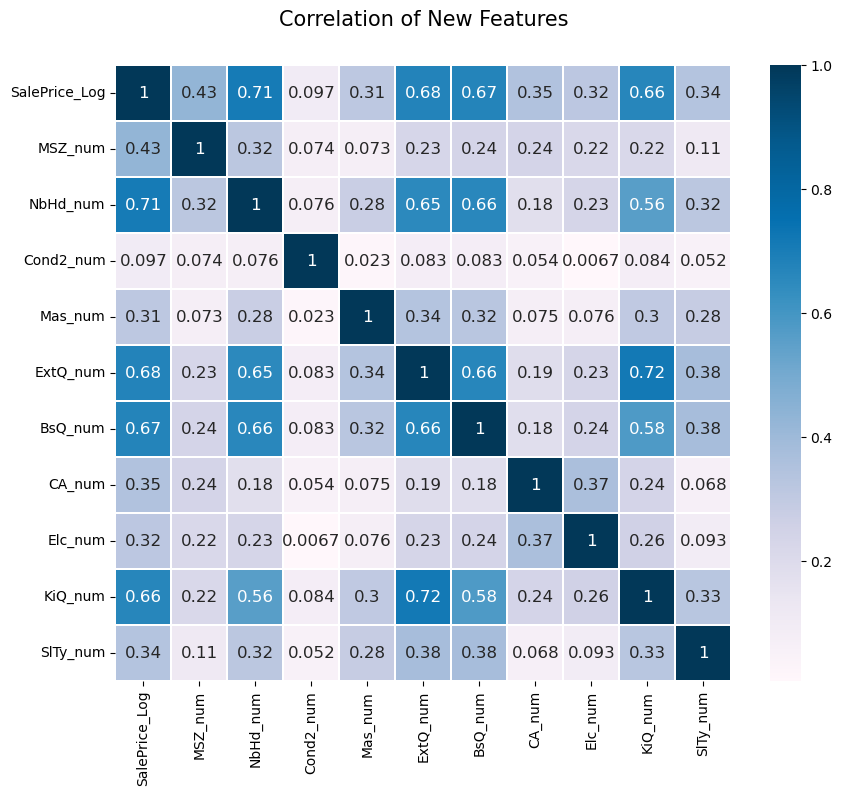

In [26]:
new_col_HM = house_df[['SalePrice_Log', 'MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']]

colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("Correlation of New Features", y = 1.05, size = 15)
sns.heatmap(new_col_HM.corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 12})

In [27]:
house_df.drop(['MSZoning','Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType', 'Cond2_num', 'Mas_num', 'CA_num', 'Elc_num', 'SlTy_num'], axis = 1, inplace = True)
house_testdf.drop(['MSZoning', 'Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType', 'Cond2_num', 'Mas_num', 'CA_num', 'Elc_num', 'SlTy_num'], axis = 1, inplace = True)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train = house_df.drop("SalePrice_Log", axis = 1).values
target_label = house_df["SalePrice_Log"].values
X_test = house_testdf.values
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size = 0.2, random_state = 2000)

In [29]:
import xgboost
regressor = xgboost.XGBRegressor(colsample_bytree = 0.4603, learning_rate = 0.06, min_child_weight = 1.8,
                                 max_depth= 3, subsample = 0.52, n_estimators = 2000,
                                 random_state= 7, ntrhead = -1)
regressor.fit(X_tr,y_tr)

[05:02:32] WARNING: ../src/learner.cc:627: 
Parameters: { "ntrhead" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4603,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.06, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1.8,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, ntrhead=-1, num_parallel_tree=1, predictor='auto',
             random_state=7, reg_alpha=0, ...)

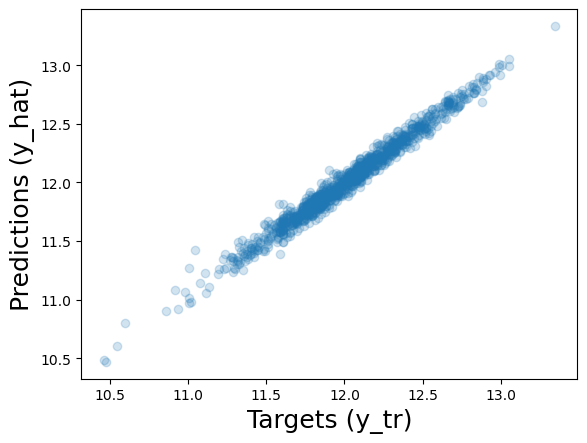

In [30]:
y_hat = regressor.predict(X_tr)

plt.scatter(y_tr, y_hat, alpha = 0.2)
plt.xlabel('Targets (y_tr)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.show()

In [31]:
regressor.score(X_tr,y_tr)

0.9777663965908275

In [32]:
pred_ans = regressor.predict(X_test)
answer_df = pd.DataFrame()
answer_df['Id'] = id_test
answer_df['SalePrice'] = pred_ans
answer_df['SalePrice'] = np.exp(answer_df['SalePrice'])
print(answer_df)

        Id      SalePrice
0     1461  109453.617188
1     1462  139323.125000
2     1463  179979.171875
3     1464  176887.484375
4     1465  185990.765625
...    ...            ...
1454  2915   78881.085938
1455  2916   84511.156250
1456  2917  158510.578125
1457  2918  106618.773438
1458  2919  233596.171875

[1459 rows x 2 columns]


In [33]:
answer_df.to_csv('/kaggle/working/house_answer.csv',index=False)